# Image Classification Models Based on Various Processing Methods Using Cross-Validation and Voting

This notebook implements and tests several classifiers for image recognition based on various processing methods, including brightness histograms, Discrete Fourier Transform (DFT), Discrete Cosine Transform (DCT), scaling, and gradients. The notebook also includes a voting-based classification model that combines the results of multiple classifiers to improve accuracy.

## Main Stages

1. **Data Preprocessing**: Loading and preparing images and class labels for training.
2. **Model Training**: Training different classifiers with various parameters.
3. **Model Evaluation**: Evaluating the accuracy of classifiers on training and test datasets, as well as performing cross-validation to obtain a stable assessment of model performance.
4. **Visualization**: Plotting graphs to analyze the dependence of classification accuracy on the number of test images and model parameters, as well as visualizing classification results.
5. **Voting**: Comparing various classifiers and applying voting-based classification to enhance final results.

In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.fftpack import dct
from skimage.transform import rescale
from IPython.display import clear_output
from IPython import display

In [2]:
images_path = 'faces'

images = []
labels = []

for label, dir_name in enumerate(sorted(os.listdir(images_path))):
    dir_path = os.path.join(images_path, dir_name)
    for image_name in os.listdir(dir_path):
        image_path = os.path.join(dir_path, image_name)
        img = cv.imread(image_path, 0)
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [3]:
class BrightnessClassifier:
    """
    Classifier based on brightness histogram
    """
    def __init__(self, hist_size=256):
        self.hist_size = hist_size
        self.train_histograms = []
        self.X_train = None
        self.y_train = None
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.train_histograms = []
        for train_image in self.X_train:
            # Calculate the histogram and normalize it
            train_hist = cv.calcHist([train_image], [0], None, [self.hist_size],[0,256])
            train_hist = cv.normalize(train_hist, train_hist).flatten()
            self.train_histograms.append(train_hist)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            # Calculate the histogram and normalize it
            test_hist = cv.calcHist([test_image], [0], None, [self.hist_size],[0,256])
            test_hist = cv.normalize(test_hist, test_hist).flatten()
            for train_hist in self.train_histograms:
                dist = np.linalg.norm(test_hist - train_hist)
                distances.append(dist)
            # Get the label of the closest match
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
            
        return np.array(predictions)

In [4]:
class DFTClassifier:
    """
    Classifier based on Discrete Fourier Transform (DFT)
    """
    def __init__(self, size=1.0):
        self.size = size
        self.X_train = None
        self.y_train = None
        self.max_row = None
        self.max_column = None
        self.train_dfts = []
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.max_row = int(X_train[0].shape[0] * self.size)
        self.max_column = int(X_train[0].shape[1] * self.size)
        self.train_dfts = []
        for train_image in self.X_train:
            train_dft = np.fft.fft2(train_image)
            train_dft = np.fft.fftshift(train_dft)
            train_dft = 20 * np.log(np.abs(train_dft) + 1e-8)  # Adding a small constant to avoid log(0)
            train_dft = train_dft[:self.max_row, :self.max_column]    
            self.train_dfts.append(train_dft)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_dft = np.fft.fft2(test_image)
            test_dft = np.fft.fftshift(test_dft)
            test_dft = 20 * np.log(np.abs(test_dft) + 1e-8)  # Adding a small constant to avoid log(0)
            test_dft = test_dft[:self.max_row, :self.max_column]
            for train_dft in self.train_dfts:
                dist = np.linalg.norm(test_dft.ravel() - train_dft.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)     
            
        return np.array(predictions)

In [5]:
class DCTClassifier:
    """
    Classifier based on Discrete Cosine Transform (DCT)
    @param: float size: Uses a rectangle of size*row and size*column from the entire image
    """
    def __init__(self, size=1.0):
        self.size = size
        self.X_train = None
        self.y_train = None
        self.max_row = None
        self.max_column = None
        self.train_dcts = []
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.max_row = int(X_train[0].shape[0] * self.size)
        self.max_column = int(X_train[0].shape[1] * self.size)
        self.train_dcts = []
        for train_image in self.X_train:
            train_dct = dct(dct(train_image.T, norm='ortho').T, norm='ortho')
            train_dct = train_dct[:self.max_row, :self.max_column]
            self.train_dcts.append(train_dct)    
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_dct = dct(dct(test_image.T, norm='ortho').T, norm='ortho')
            test_dct = test_dct[:self.max_row, :self.max_column]
            for train_dct in self.train_dcts:
                dist = np.linalg.norm(train_dct.ravel() - test_dct.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
        
        return np.array(predictions)

In [6]:
class ScaleClassifier:
    """
    Classifier based on image scaling
    @param array-like sizes: Represents an array of scaling factors
    """
    def __init__(self, sizes=[1.0]):
        self.sizes = sizes
        self.train_rescaled_imgs = []
        self.X_train = None
        self.y_train = None
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.train_rescaled_imgs = []
        for train_image in self.X_train:
            rescaled = self.get_rescaled_imgs(train_image)
            self.train_rescaled_imgs.append(rescaled)
    
    def get_rescaled_imgs(self, img):
        rescaled_imgs = []
        for size in self.sizes:   
            rescaled_img = rescale(img, size, mode='constant', anti_aliasing=False, channel_axis=-1)
            rescaled_imgs.append(rescaled_img)
        return rescaled_imgs       
    
    def get_avg_distance(self, rescaled_img1, rescaled_img2):
        total_dist = 0
        for i in range(len(self.sizes)):
            total_dist += np.linalg.norm(rescaled_img1[i].ravel() - rescaled_img2[i].ravel())
        
        return total_dist / len(self.sizes)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            test_rescaled_img = self.get_rescaled_imgs(test_image)
            for train_rescaled_img in self.train_rescaled_imgs:
                dist = self.get_avg_distance(test_rescaled_img, train_rescaled_img)
                distances.append(dist)
            # Select the label of the nearest training image
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
            
        return np.array(predictions)   

In [7]:
class GradientClassifier:
    """
    Classifier based on gradients
    @param: int ksize: Kernel size for the Sobel operator
    """
    def __init__(self, ksize=3):
        self.ksize = ksize
        self.X_train = None
        self.y_train = None
        self.train_gradients = []
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train= y_train
        self.train_gradients = []
        for train_image in self.X_train:
            grad_x = cv.Sobel(train_image, cv.CV_64F, 1, 0, ksize=self.ksize)
            grad_y = cv.Sobel(train_image, cv.CV_64F, 0, 1, ksize=self.ksize)
            train_grad = np.sqrt(grad_x**2 + grad_y**2)
            self.train_gradients.append(train_grad)
    
    def predict(self, test_images):
        predictions = []
        for test_image in test_images:
            distances = []
            grad_x = cv.Sobel(test_image, cv.CV_64F, 1, 0, ksize=self.ksize)
            grad_y = cv.Sobel(test_image, cv.CV_64F, 0, 1, ksize=self.ksize)
            test_grad = np.sqrt(grad_x**2 + grad_y**2)
            for train_grad in self.train_gradients:
                dist = np.linalg.norm(test_grad.ravel() - train_grad.ravel())
                distances.append(dist)
            prediction = self.y_train[np.argmin(distances)]
            predictions.append(prediction)
        
        return np.array(predictions)

In [8]:
class VotingClassifier:
    """
    Classifier based on majority voting
    """
    def __init__(self, estimators, voting='hard'):
        self.estimators = estimators
        self.voting = voting
        
    def fit(self, X_train, y_train):
        for estimator in self.estimators:
            estimator.fit(X_train, y_train)
    
    def predict(self, X_test):
        if self.voting == 'hard':
            return self._hard_voting(X_test)
        elif self.voting == 'soft':
            return self._soft_voting(X_test)
        else:
            raise ValueError("Voting must be 'hard' or 'soft'")
    
    def _hard_voting(self, X_test):
        predictions = []
        for estimator in self.estimators:
            y_pred = estimator.predict(X_test)
            predictions.append(y_pred)
        predictions = np.array(predictions)
        # Apply majority voting
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return majority_votes
    
    def _soft_voting(self, X_test):
        probabilities = np.zeros((len(X_test), len(self.estimators[0].classes_)))
        for estimator in self.estimators:
            probas = estimator.predict_proba(X_test)
            probabilities += probas
        # Average the probabilities and get the class with the highest probability
        average_probas = probabilities / len(self.estimators)
        return np.argmax(average_probas, axis=1)

In [9]:
def accuracy_score(y_pred, y_test):
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    return np.sum(y_pred == y_test) / len(y_test)

In [10]:
# test_size = len(np.unique(labels))  # Number of unique classes
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, 
                                                    random_state=25, stratify=labels)

# Testing on the training set

## Brightness histogram

In [11]:
brightness_clf = BrightnessClassifier()

In [12]:
brightness_clf.fit(X_train, y_train)

In [13]:
%%time
y_pred = brightness_clf.predict(X_train)

CPU times: total: 156 ms
Wall time: 312 ms


In [14]:
accuracy_score(y_pred, y_train)

1.0

## Discrete Fourier Transform

In [15]:
dft_clf = DFTClassifier()

In [16]:
dft_clf.fit(X_train, y_train)

In [17]:
%%time
y_pred = dft_clf.predict(X_train)

CPU times: total: 625 ms
Wall time: 13.9 s


In [18]:
accuracy_score(y_pred, y_train)

1.0

## Discrete Cosine Transform

In [19]:
dct_clf = DCTClassifier()

In [20]:
dct_clf.fit(X_train, y_train)

In [21]:
%%time
y_pred = dct_clf.predict(X_train)

CPU times: total: 703 ms
Wall time: 13.1 s


In [22]:
accuracy_score(y_pred, y_train)

1.0

## Scaling

In [23]:
scale_clf = ScaleClassifier(sizes=[1.0, 0.9, 0.8, 0.5])

In [24]:
%%time
scale_clf.fit(X_train, y_train)

CPU times: total: 250 ms
Wall time: 462 ms


In [25]:
%%time
y_pred = scale_clf.predict(X_train)

CPU times: total: 1.48 s
Wall time: 18.2 s


In [26]:
accuracy_score(y_pred, y_train)

1.0

## Gradient

In [27]:
gradient_clf = GradientClassifier()

In [28]:
gradient_clf.fit(X_train, y_train)

In [29]:
%%time
y_pred = gradient_clf.predict(X_train)

CPU times: total: 734 ms
Wall time: 12.7 s


In [30]:
accuracy_score(y_pred, y_train)

1.0

# Testing on the test set

In [31]:
def plot_acc(test_sizes, accuracies, clf_name):
    plt.figure(figsize=(10, 6))
    plt.plot(test_sizes, accuracies, marker='o', linestyle='-', color='b', markersize=3)
    plt.xlabel('Size')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for {clf_name}')
    plt.grid(True)

    plt.show()

## Brightness histogram

**Classification with a default parameter `size=256`**

In [32]:
brightness_clf = BrightnessClassifier()

In [33]:
brightness_clf.fit(X_train, y_train)

In [34]:
%%time
y_pred = brightness_clf.predict(X_test)

CPU times: total: 78.1 ms
Wall time: 95.8 ms


In [35]:
accuracy_score(y_pred, y_test)

0.9875

**Classification with the `size` parameter in the range `[3..256]`**

In [36]:
%%time
accuracies = []
for size in range(3, 257):
    brightness_clf = BrightnessClassifier(hist_size=size)
    brightness_clf.fit(X_train, y_train)
    y_pred = brightness_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: total: 10.9 s
Wall time: 19.9 s


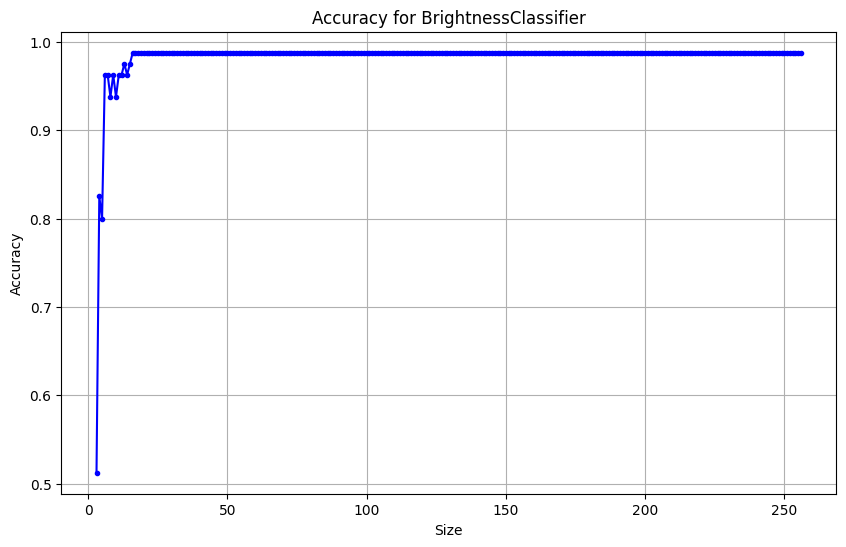

In [37]:
plot_acc(range(3, 257), accuracies, 'BrightnessClassifier')

In [38]:
print('Optimal size parameter:', np.arange(3, 257, 1)[np.argmax(accuracies)])
print('Accuracy:', max(accuracies))

Optimal size parameter: 16
Accuracy: 0.9875


## Discrete Fourier Transform

**Classification with a default parameter `size=1.0`**

In [39]:
dft_clf = DFTClassifier()

In [40]:
dft_clf.fit(X_train, y_train)

In [41]:
%%time
y_pred = dft_clf.predict(X_test)

CPU times: total: 172 ms
Wall time: 3.6 s


In [42]:
accuracy_score(y_pred, y_test)

0.9375

**Classification with the `size` parameter in the range `[0.05..1.0]`**

In [43]:
%%time
accuracies = []
for size in np.arange(0.05, 1.05, 0.05):
    dft_clf = DFTClassifier(size=size)
    dft_clf.fit(X_train, y_train)
    y_pred = dft_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: total: 5.05 s
Wall time: 13.2 s


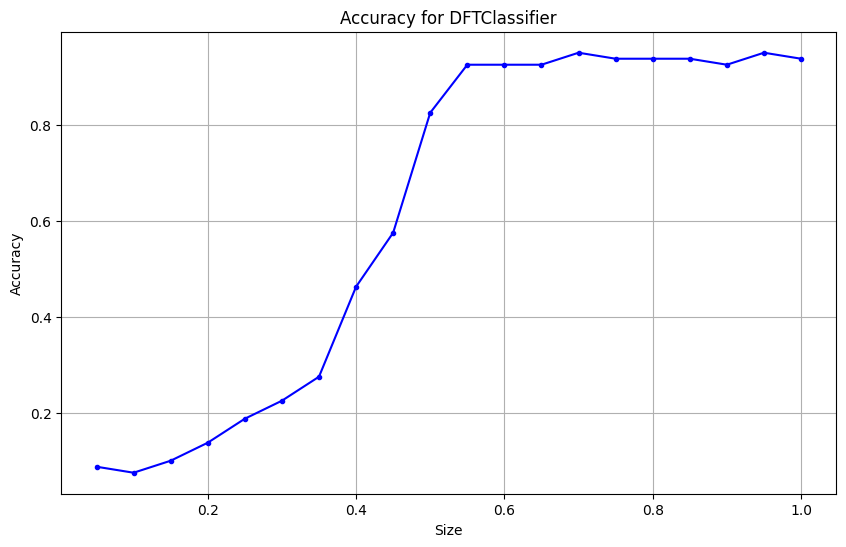

In [44]:
plot_acc(np.arange(0.05, 1.05, 0.05), accuracies, 'DFTClassifier')

In [45]:
print('Optimal size parameter:', np.arange(0.05, 1.05, 0.05)[np.argmax(accuracies)])
print('Accuracy:', max(accuracies))

Optimal size parameter: 0.7000000000000001
Accuracy: 0.95


## Discrete Cosine Transform

**Classification with a default parameter `size=1.0`**

In [46]:
dct_clf = DCTClassifier()

In [47]:
dct_clf.fit(X_train, y_train)

In [48]:
%%time
y_pred = dct_clf.predict(X_test)

CPU times: total: 188 ms
Wall time: 3.18 s


In [49]:
accuracy_score(y_pred, y_test)

0.975

**Classification with the `size` parameter in the range `[0.05..1.0]`**

In [50]:
%%time
accuracies = []
for size in np.arange(0.05, 1.05, 0.05):
    dct_clf = DCTClassifier(size=size)
    dct_clf.fit(X_train, y_train)
    y_pred = dct_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: total: 3.8 s
Wall time: 9.24 s


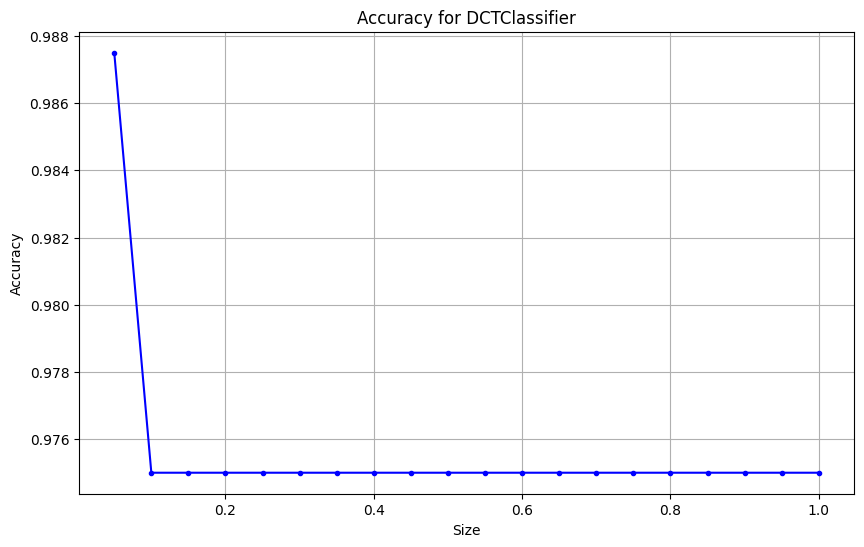

In [51]:
plot_acc(np.arange(0.05, 1.05, 0.05), accuracies, 'DCTClassifier')

In [52]:
print('Оптимальный параметр size:', np.arange(0.05, 1.05, 0.05)[np.argmax(accuracies)])
print('Точность:', max(accuracies))

Оптимальный параметр size: 0.05
Точность: 0.9875


## Scaling

In [53]:
scale_clf = ScaleClassifier(sizes=[0.1, 0.5, 0.8])

In [54]:
%%time
scale_clf.fit(X_train, y_train)

CPU times: total: 125 ms
Wall time: 280 ms


In [55]:
%%time
y_pred = scale_clf.predict(X_test)

CPU times: total: 359 ms
Wall time: 633 ms


In [56]:
accuracy_score(y_pred, y_test)

0.9875

**Classification with the `size` parameter in the range `[0.05..1.0]`**

In [57]:
%%time
accuracies = []
for size in np.arange(0.05, 1.05, 0.05):
    scale_clf = ScaleClassifier(sizes=[size])
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: total: 3.88 s
Wall time: 9.48 s


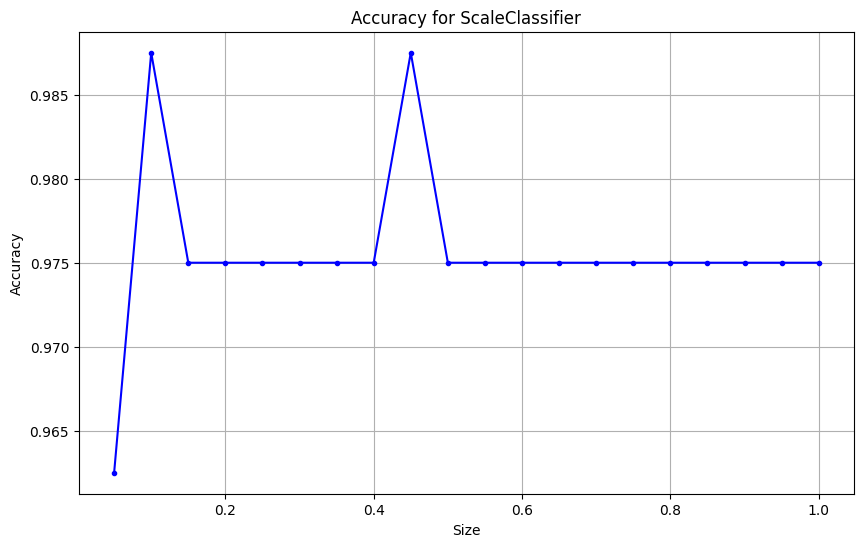

In [58]:
plot_acc(np.arange(0.05, 1.05, 0.05), accuracies, 'ScaleClassifier')

**Classification with the `sizes` parameter in the range `[0.05..1.0]`.**

Previous parameters are not deleted on each iteration

In [59]:
%%time
accuracies = []
sizes = []
for size in np.arange(0.05, 1.05, 0.05):
    sizes.append(size)
    scale_clf = ScaleClassifier(sizes=sizes)
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: total: 24.5 s
Wall time: 59.8 s


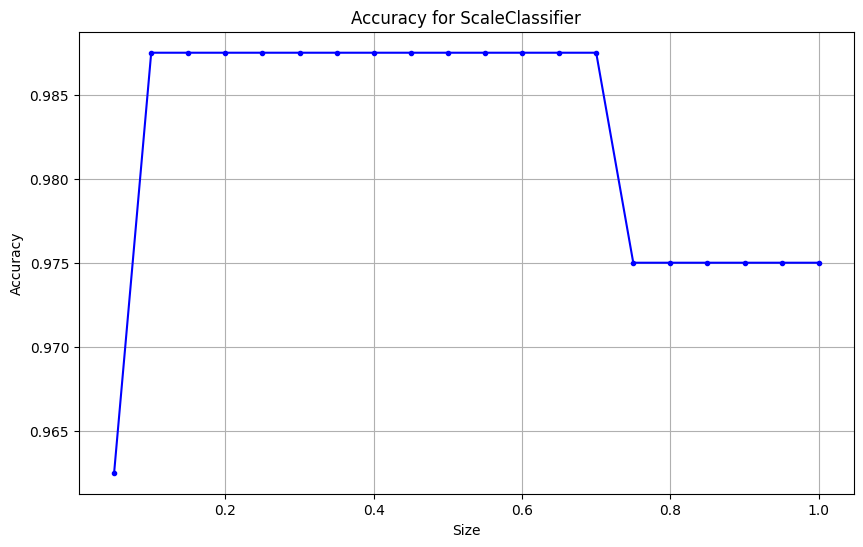

In [60]:
plot_acc(np.arange(0.05, 1.05, 0.05), accuracies, 'ScaleClassifier')

In [61]:
print('Optimal set of parameters:', sizes[:np.argmax(accuracies) + 1])
print('Accuracy:', np.max(accuracies))

Optimal set of parameters: [0.05, 0.1]
Accuracy: 0.9875


## Gradient

**Classification with the default parameter `ksize=-1`.    
In this case, a `3x3 Scharr` filter is used.**

In [62]:
gradient_clf = GradientClassifier()

In [63]:
gradient_clf.fit(X_train, y_train)

In [64]:
%%time
y_pred = gradient_clf.predict(X_test)

CPU times: total: 484 ms
Wall time: 3.29 s


In [65]:
accuracy_score(y_pred, y_test)

0.8125

**Classification with the `ksize` parameter in the range `[3..31]` with a step of `2`** 

In [66]:
%%time
accuracies = []
for ksize in range(3, 32, 2):
    gradient_clf = GradientClassifier(ksize=ksize)
    gradient_clf.fit(X_train, y_train)
    y_pred = gradient_clf.predict(X_test)
    accuracies.append(accuracy_score(y_pred, y_test))

CPU times: total: 4.48 s
Wall time: 49.7 s


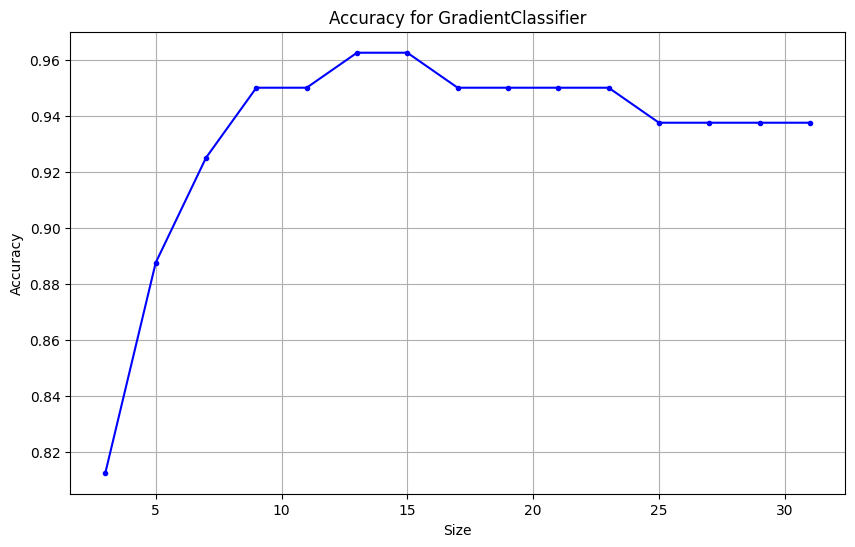

In [67]:
plot_acc(range(3, 32, 2), accuracies, 'GradientClassifier')

In [68]:
print('Optimal ksize parameter:', list(range(3, 32, 2))[np.argmax(accuracies)])
print('Accuracy:', max(accuracies))

Optimal ksize parameter: 13
Accuracy: 0.9625


# Cross-Validation of the Original Data

In [69]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

In [70]:
%%time
bright_cv_scores = []
dft_cv_scores = []
dct_cv_scores = []
scale_cv_scores = []
grad_cv_scores = []
for i, (train_idx, test_idx) in enumerate(skf.split(images, labels), start=1):
    clear_output(wait=True)
    print(i)
    X_train, y_train = images[train_idx], labels[train_idx]
    X_test, y_test = images[test_idx], labels[test_idx]

    brightness_clf = BrightnessClassifier()    
    brightness_clf.fit(X_train, y_train)
    y_pred = brightness_clf.predict(X_test)
    bright_cv_scores.append(accuracy_score(y_pred, y_test))
    
    dft_clf = DFTClassifier(size=0.55)
    dft_clf.fit(X_train, y_train)
    y_pred = dft_clf.predict(X_test)
    dft_cv_scores.append(accuracy_score(y_pred, y_test))
    
    dct_clf = DCTClassifier(size=0.1)
    dct_clf.fit(X_train, y_train)
    y_pred = dct_clf.predict(X_test)
    dct_cv_scores.append(accuracy_score(y_pred, y_test))
    
    scale_clf = ScaleClassifier(sizes=[0.05, 0.1, 0.15])
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    scale_cv_scores.append(accuracy_score(y_pred, y_test))
    
    gradient_clf = GradientClassifier(ksize=29)
    gradient_clf.fit(X_train, y_train)
    y_pred = gradient_clf.predict(X_test)
    grad_cv_scores.append(accuracy_score(y_pred, y_test))

10
CPU times: total: 7.94 s
Wall time: 31 s


In [71]:
print('BrightnessClassifier, accuracy on cross-validation:', np.mean(bright_cv_scores))
print('DFTClassifier, accuracy on cross-validation:', np.mean(dft_cv_scores))
print('DCTClassifier, accuracy on cross-validation:', np.mean(dct_cv_scores))
print('ScaleClassifier, accuracy on cross-validation:', np.mean(scale_cv_scores))
print('GradientClassifier, accuracy on cross-validation:', np.mean(grad_cv_scores))

BrightnessClassifier, accuracy on cross-validation: 0.9875
DFTClassifier, accuracy on cross-validation: 0.89
DCTClassifier, accuracy on cross-validation: 0.9800000000000001
ScaleClassifier, accuracy on cross-validation: 0.97
GradientClassifier, accuracy on cross-validation: 0.9475


## Dependence of Recognition Accuracy on the Number of Test Images in the Dataset

In [72]:
%%time
bright_scores = []
dft_scores = []
dct_scores = []
scale_scores = []
grad_scores = []
for i, test_size in enumerate(range(40, 170, 10), start=1):
    clear_output(wait=True)
    print(f'Iteration {i} from {len(range(40, 170, 10))}')
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, 
                                                        random_state=25, stratify=labels)
    brightness_clf = BrightnessClassifier()    
    brightness_clf.fit(X_train, y_train)
    y_pred = brightness_clf.predict(X_test)
    bright_scores.append(accuracy_score(y_pred, y_test))
    
    dft_clf = DFTClassifier(size=0.55)
    dft_clf.fit(X_train, y_train)
    y_pred = dft_clf.predict(X_test)
    dft_scores.append(accuracy_score(y_pred, y_test))
    
    dct_clf = DCTClassifier(size=0.1)
    dct_clf.fit(X_train, y_train)
    y_pred = dct_clf.predict(X_test)
    dct_scores.append(accuracy_score(y_pred, y_test))
    
    scale_clf = ScaleClassifier(sizes=[0.05, 0.1, 0.15])
    scale_clf.fit(X_train, y_train)
    y_pred = scale_clf.predict(X_test)
    scale_scores.append(accuracy_score(y_pred, y_test))
    
    gradient_clf = GradientClassifier(ksize=29)
    gradient_clf.fit(X_train, y_train)
    y_pred = gradient_clf.predict(X_test)
    grad_scores.append(accuracy_score(y_pred, y_test))

Iteration 13 from 13
CPU times: total: 16.3 s
Wall time: 1min 11s


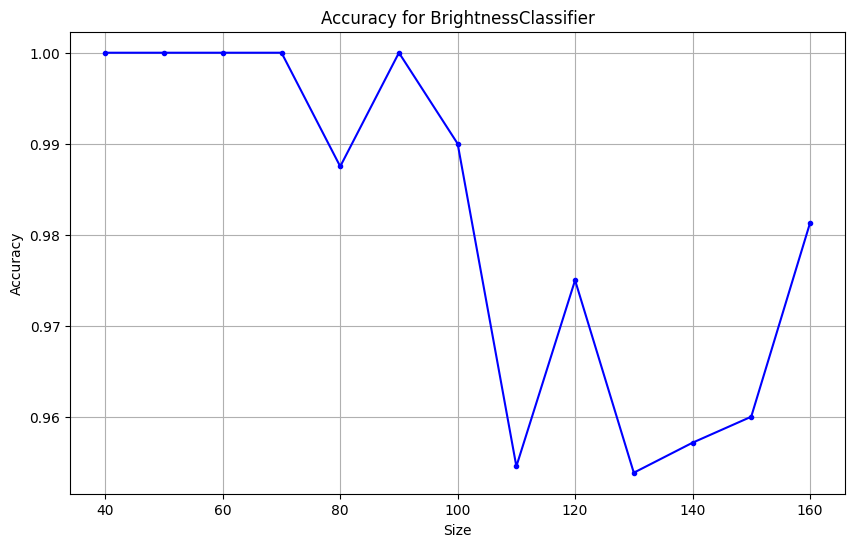

In [73]:
plot_acc(range(40, 170, 10), bright_scores, 'BrightnessClassifier')

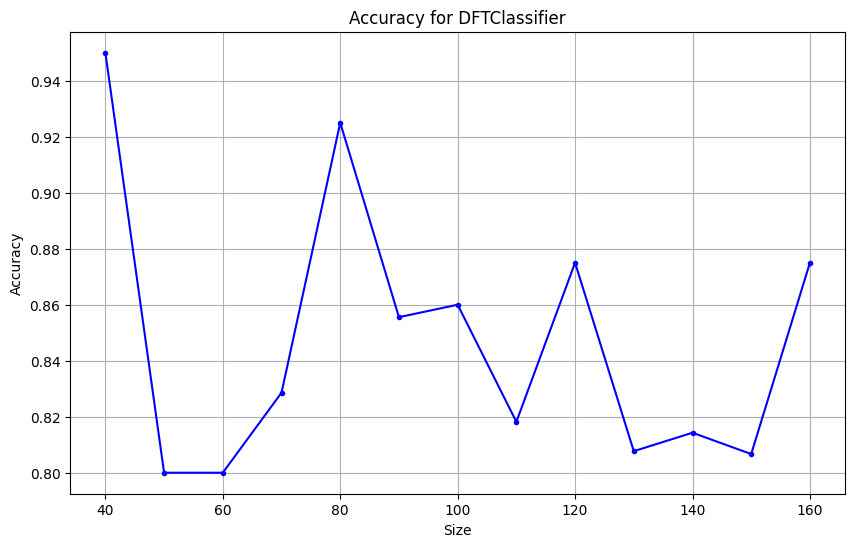

In [74]:
plot_acc(range(40, 170, 10), dft_scores, 'DFTClassifier')

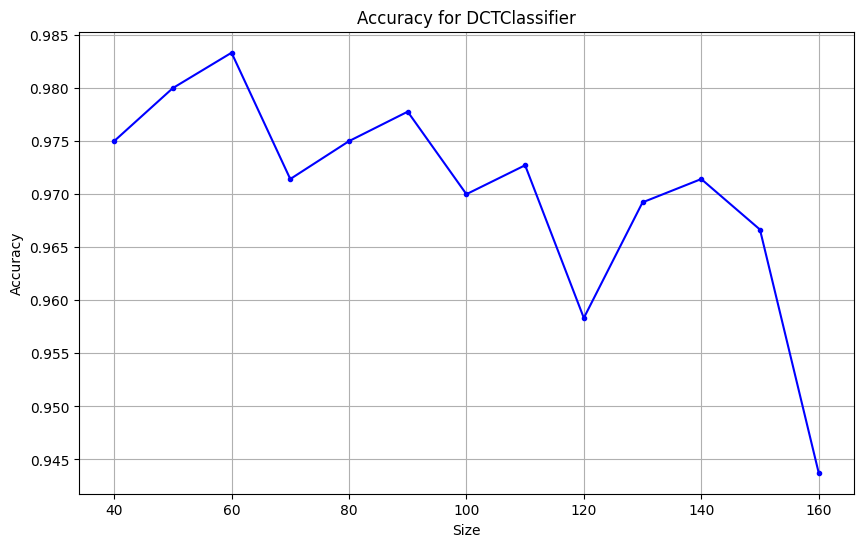

In [75]:
plot_acc(range(40, 170, 10), dct_scores, 'DCTClassifier')

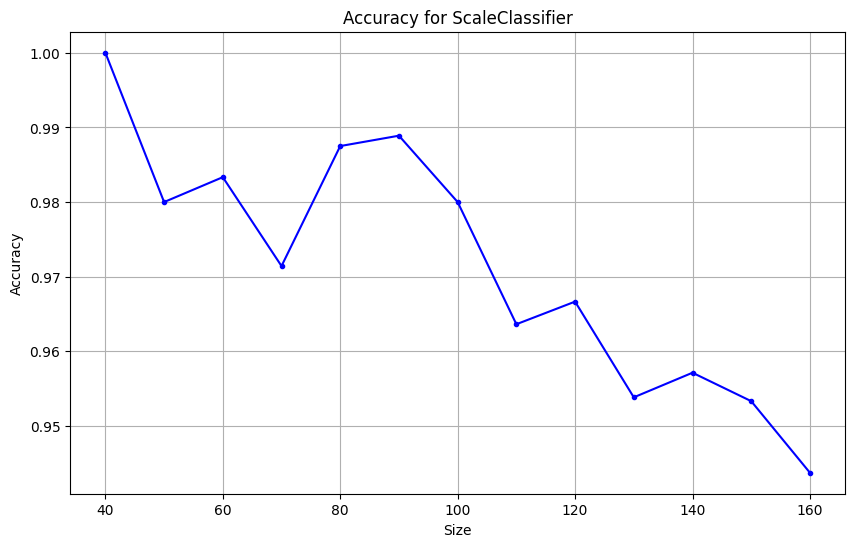

In [76]:
plot_acc(range(40, 170, 10), scale_scores, 'ScaleClassifier')

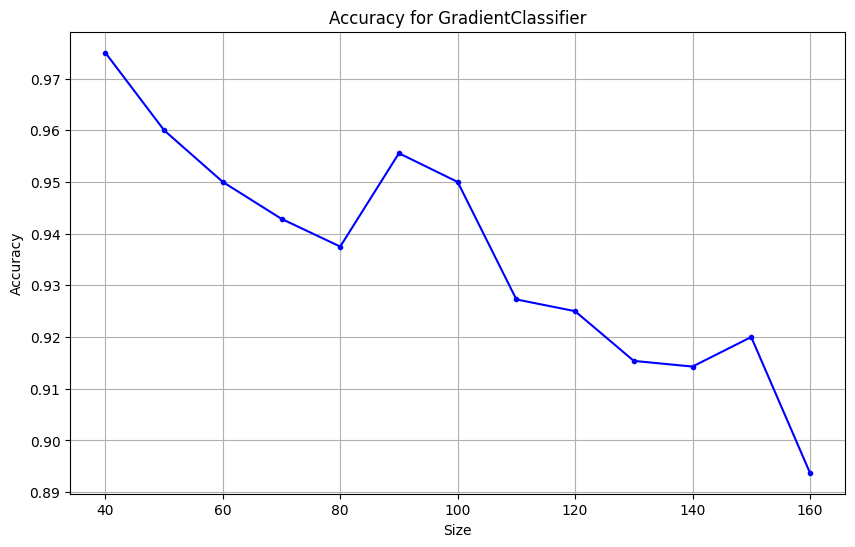

In [77]:
plot_acc(range(40, 170, 10), grad_scores, 'GradientClassifier')

## Visualization of Images

In [78]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=len(np.unique(labels)), 
                                                    random_state=25, stratify=labels)

In [79]:
brightness_clf = BrightnessClassifier()    
brightness_clf.fit(X_train, y_train)
y_pred_bright = brightness_clf.predict(X_test)

dft_clf = DFTClassifier()
dft_clf.fit(X_train, y_train)
y_pred_dft = dft_clf.predict(X_test)

dct_clf = DCTClassifier()
dct_clf.fit(X_train, y_train)
y_pred_dct = dct_clf.predict(X_test)

scale_clf = ScaleClassifier()
scale_clf.fit(X_train, y_train)
y_pred_scale = scale_clf.predict(X_test)

gradient_clf = GradientClassifier()
gradient_clf.fit(X_train, y_train)
y_pred_grad = gradient_clf.predict(X_test)

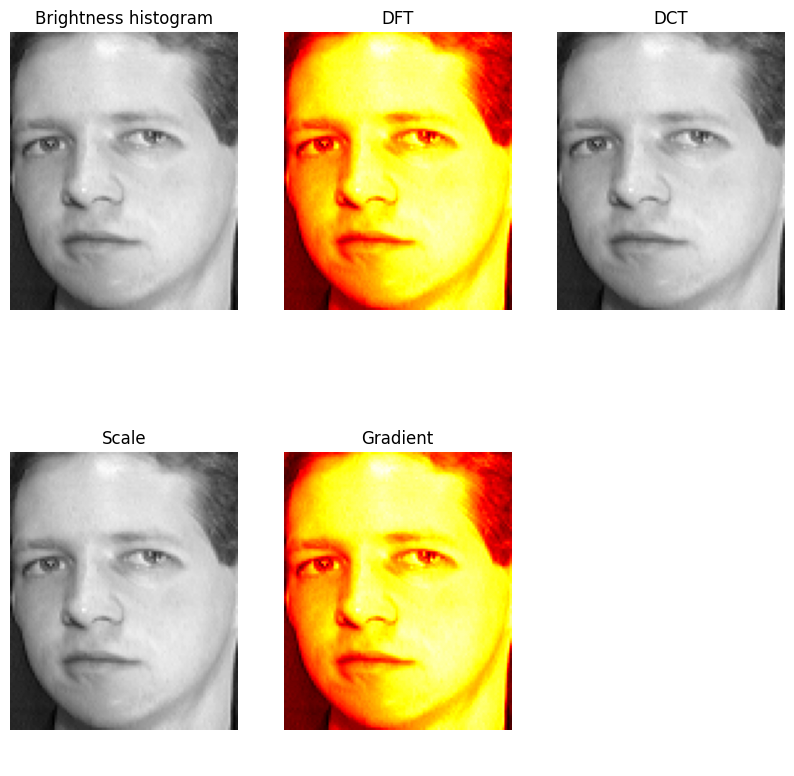

In [80]:
fig, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()

# Заголовки методов
titles = ["Brightness histogram", "DFT", "DCT", "Scale", "Gradient"]

# Предсказания для каждого метода
predictions = [y_pred_bright, y_pred_dft, y_pred_dct, y_pred_scale, y_pred_grad]

for i, (true_label, img) in enumerate(zip(y_test, X_test)):
    for ax, title, y_pred in zip(axs, titles, predictions):
        if true_label == y_pred[i]:
            ax.imshow(img, cmap="gray")
        else:
            ax.imshow(img, cmap="hot")
        ax.set_title(title)
        ax.axis('off')

    axs[5].axis('off')
    
    display.display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.5)

# Classification Based on Voting Principle

**Classification with Default Parameters**

In [81]:
estimators = [BrightnessClassifier(), DFTClassifier(), DCTClassifier(), 
              ScaleClassifier(sizes=[0.5]), GradientClassifier(ksize=3)]
voting_classifier = VotingClassifier(estimators=estimators)

In [82]:
voting_classifier.fit(X_train, y_train)

In [83]:
%%time
y_pred = voting_classifier.predict(X_test)

CPU times: total: 1.16 s
Wall time: 5.98 s


In [84]:
accuracy_score(y_pred, y_test)

0.975

**Classification with Optimal Parameters for Each Classifier**

In [85]:
estimators = [BrightnessClassifier(hist_size=256), DFTClassifier(size=0.55), DCTClassifier(size=0.1), 
              ScaleClassifier(sizes=[0.05, 0.1, 0.15]), GradientClassifier(ksize=29)]
voting_classifier = VotingClassifier(estimators=estimators)

In [86]:
voting_classifier.fit(X_train, y_train)

In [87]:
%%time
y_pred = voting_classifier.predict(X_test)

CPU times: total: 312 ms
Wall time: 2.44 s


In [88]:
accuracy_score(y_pred, y_test)

0.975

**Dependence of Recognition Accuracy on the Number of Test Images in the Dataset**

In [89]:
%%time
scores = []
for i, test_size in enumerate(range(40, 210, 10), start=1):
    clear_output(wait=True)
    print(f'Iteration {i} from {len(range(40, 210, 10))}')
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, 
                                                        random_state=25, stratify=labels)
    
    estimators = [BrightnessClassifier(hist_size=256), DFTClassifier(size=0.55), DCTClassifier(size=0.1), 
                  ScaleClassifier(sizes=[0.05, 0.1, 0.15]), GradientClassifier(ksize=29)]
    voting_classifier = VotingClassifier(estimators=estimators)
    voting_classifier.fit(X_train, y_train)
    y_pred = voting_classifier.predict(X_test)
    scores.append(accuracy_score(y_pred, y_test))

Iteration 17 from 17
CPU times: total: 19.1 s
Wall time: 1min 38s


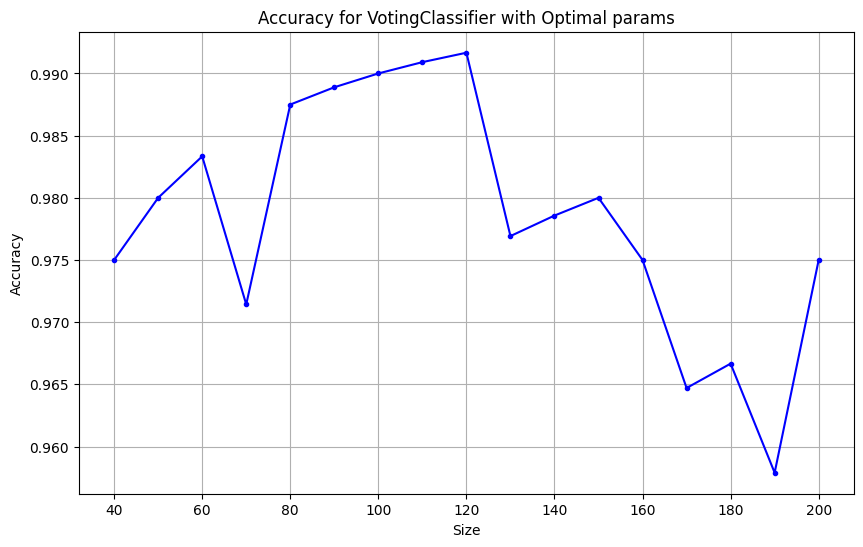

In [90]:
plot_acc(range(40, 210, 10), scores, 'VotingClassifier with Optimal params')

**Cross-Validation**

In [91]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

In [92]:
%%time
cv_scores = []
for i, (train_idx, test_idx) in enumerate(skf.split(images, labels), start=1):
    clear_output(wait=True)
    print(i)
    X_train, y_train = images[train_idx], labels[train_idx]
    X_test, y_test = images[test_idx], labels[test_idx]

    estimators = [BrightnessClassifier(hist_size=256), DFTClassifier(size=0.55), DCTClassifier(size=0.1), 
                  ScaleClassifier(sizes=[0.05, 0.1, 0.15]), GradientClassifier(ksize=29)]
    voting_classifier = VotingClassifier(estimators=estimators)
    voting_classifier.fit(X_train, y_train)
    y_pred = voting_classifier.predict(X_test)
    cv_scores.append(accuracy_score(y_pred, y_test))

print('Accuracy on cross-validation:', np.mean(cv_scores))

10
Accuracy on cross-validation: 0.99
CPU times: total: 7.69 s
Wall time: 30.5 s


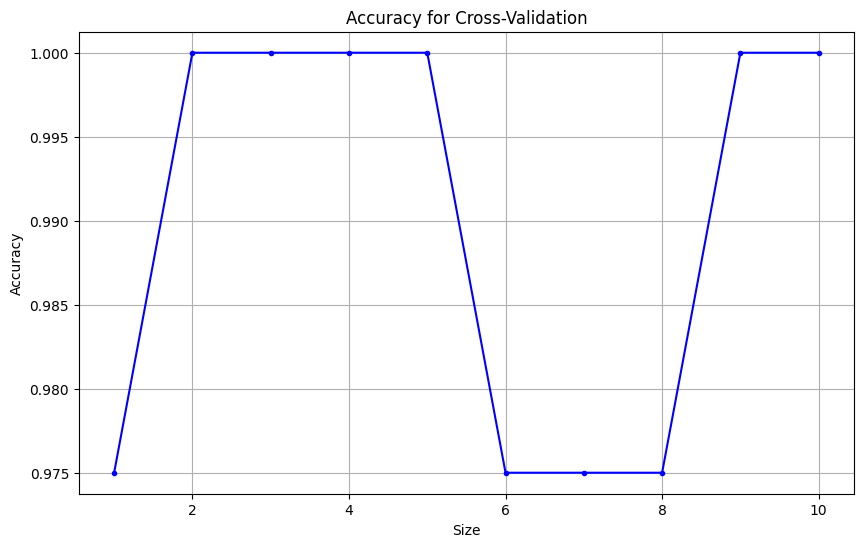

In [96]:
plot_acc(np.arange(1, len(cv_scores) + 1), cv_scores, 'Cross-Validation')